In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv


read_csv csv 파일을 불러온다.
usecols= 네번째 행 확진자 수만 사용
dataframe.values 첫번째 열의 타이틀은 가져오지 않는다.
dataset.astype('float32') 실수형으로 변경

In [ ]:
!git clone https://github.com/yhlee1627/deeplearning.git
dataframe = read_csv("deeplearning/corona_daily.csv", usecols=[3], engine="python", skipfooter=3)
print(dataframe)
dataset = dataframe.values
dataset = dataset.astype('float32')


데이터의 정규화를 위한 함수 MinMaxScaler
sklearn의 전처리 함수 feature_range=(0, 1) 데이터를 0과 1 사이의 값으로 바꾸어서 사용
train_test_split Dataset을 훈련데이터와 검증데이터로 나눈다.
test_size=0.2 검증 데이터를 20%로 분리한다.
shuffle=False 데이터를 순서대로 가져오며 섞지 않는다.

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
Dataset = scaler.fit_transform(dataset)
# print(Dataset)
train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False)
print(len(train_data), len(test_data))

89 23


데이터 형태 변경
순환 신경망(RNN)모델은 연속된 데이터를 사용하여 이후의 값을 예측
한줄로 나열된 데이터를 아래와 같은 형태로 변경한다.
[1,2,3] [4], 
[2,3,4] [5],
...
[7,8,9] [10],

In [5]:
# dataset 원래 데이터
# look_back 연속되는 데이터의 갯수
def create_dataset(dataset, look_back):
    x_data = []
    y_data = []
    for i in range(len(dataset) - look_back):
        data = dataset[i:(i + look_back), 0]
        x_data.append(data)
        y_data.append(dataset[i + look_back, 0])
    return np.array(x_data), np.array(y_data)

입력데이터를 생성
look_back : 3일치 데이터를 사용하겠다.
train_data : 훈련 데이터
test_data : 검증 데이터
x_train: 3일치 훈련 데이터
y_train: 4일째 훈련 데이터
x_test: 3일치 검증 데이터
y_test: 4일째 검증 데이터

In [13]:
look_back = 3
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(86, 3) (86,)
(20, 3) (20,)


인공지능 모델에 넣어줄 형태로 변환하기
훈련데이터와 검증데이터는 86개며 1X3의 형태로 만든다.

In [17]:
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

(86, 1, 3)
(20, 1, 3)


인공지능 모델 만들기
SimpleRNN 순환 신경만 모델을 사용 뉴런의 수는 3개, 
input_shape=(1, look_back) 데이터이 형태는 몇개의 연속된 데이터를 넣을지에 따라 달라진다.
Dense(1, activation="linear") 최종 예측값은 연속된 데이터 이후의 값 확진자 수만 나오기 때문에 1
compile(loss='mse', optimizer='adam') 인공지능의 계산 방법 결정
    손실함수는 mse(평균 제곱 오차, mean_squared_error), 옵티마이저는 adam(Adaptive Moment Estimation)을 사용
    실제 확진자 수와 예측한 값의 차이로 오차를 나타낼수 있기에 평균 제곱 오차를 사용
summary() 모델을 구축한 순서대로 표로 구성

In [ ]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(1, look_back)))
model.add(Dense(1, activation="linear"))
model.compile(loss='mse', optimizer='adam')
model.summary()

mean_squared_error : 결과의 정확도를 계산하기 위한 함수 
연속된 값을 예측하는 회귀의 문제로 오차를 계산하는 방법
실제값과 예측값의 차이를 사용하여 오류를 구하는 역할

모델 학습시키기 keras
X_train 입력 데이터
y_train 출력 데이터
epochs 반복 횟수
batch_size 한번에 학습시킬 데이터 양
verbose 학습의 진행 결과를 어떻게 표시할지 결정

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

데이터 예측하기
실제 데이터를 예측한 값과 실제 데이터의 차이를 봐야함
정규화 데이터가 아니라 실제 확진자 수 데이터가 필요하다.
RNN 모델을 통해 나온 예측값을정규화 되기 전의 값으로 변환하여야 하며 실제 값 또한 정규화되기 전의 원래 값으로 변환하여야 한다.

실제 데이터를 넣었을때 어떻게 예측값이 반환하는지 본다.
1 predict: 입력 데이터를 모델에 넣어서 출력값을 얻는다.
2 훈련데이터를 X_train, X_test를 넣는다.
3 inverse_transform 을 통해서 원래의 값으로 변환한다

TrainPredict TestPredict 예측값
Y_train Y_test 실제값

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

TrainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([y_train])

TestPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([y_test])

print(TrainPredict)
print(Y_train)

모델의 정확도 살펴보기
평균 제곱근 오차(Root Mean Squared Error) 평균값을 제곱근 한 값이다.

In [ ]:
trainScore = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:,0]))
print('Train Score: %.2f RMSE' %(trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:,0]))
print('Test Score: %.2f RMSE' %(testScore))

결과를 그래프로 확인하기
실제 데이터과 동일한 그래프를 만든다.

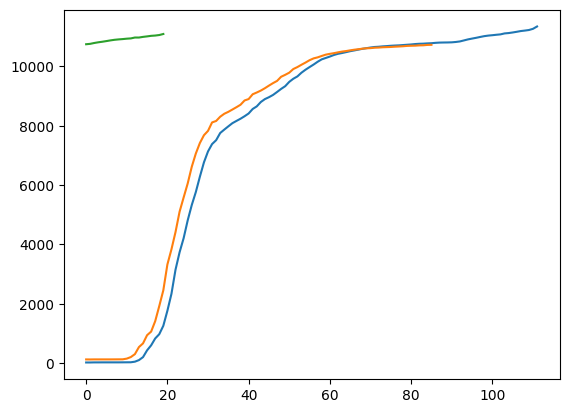

In [33]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(TrainPredict)+look_back,:] = TrainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(TrainPredict)+(look_back)*2:len(dataset),:] = TestPredict

plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()